# Data Cleaning and Preparation

In [71]:
# importing the necessary modules
import random
import json
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


import nltk
nltk.download('punkt')
nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer
from keras.models import Sequential
from keras.layers import Dense,Dropout
from keras.optimizers import SGD
from tensorflow.keras.utils import plot_model

lemmatizer=WordNetLemmatizer()


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Tapiwa\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Tapiwa\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [72]:
# Opening the intents file
with open('intents.json') as json_file:
    intents = json.load(json_file)

In [73]:

words=[]
classes=[]
documents=[]
ignore_letters=['?','!','.',',']

# Tokenizing the patterns (possible user responses)
for intent in intents['intents']:
  for pattern in intent['patterns']:
    word_list=nltk.word_tokenize(pattern)
    words.extend(word_list)

    # extracting a list of documents from the tokenized words and their associated tag
    documents.append((word_list,intent['tag']))
    
    #extracting a list of classes from the tags
    if intent['tag'] not in classes:
      classes.append(intent['tag'])

In [74]:
# lemmatizing words the tokenized words and eliminating punctuation symbols
words =[lemmatizer.lemmatize(word) for word in words if word not in ignore_letters]

# reducing the list to a set of unique values and then sorting them
words = sorted(set(words))
classes=sorted(set(classes))

# pickling the tokenized words and classes
pickle.dump(words,open('words.pkl','wb'))
pickle.dump(classes,open('classes.pkl','wb'))


## Building the Training Data Set

In [75]:
# creating empty lists
training=[]
output_empty=[0]*len(classes)


# creating a training data from the documents (one by one)
for document in documents:
  bag=[]
  word_patterns=document[0]
  words = [lemmatizer.lemmatize(word) for word in words if word and word not in ignore_letters]
  for word in words:
    bag.append(1) if word in word_patterns else bag.append(0)

  # creating the output row (y values)
  output_row=list(output_empty)
  output_row[classes.index(document[1])]=1

  # adding the data to the training dataset
  training.append([bag,output_row])

In [76]:
# randomising the data in the tarining data set and converting into a numpy array
random.shuffle(training)
training=np.array(training)

C:\Users\Tapiwa\AppData\Local\Programs\Python\Python37\lib\site-packages\ipykernel_launcher.py:3: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  This is separate from the ipykernel package so we can avoid doing imports until


In [77]:
#splitting into the x and y values
train_x=list(training[:,0])
train_y=list(training[:,1])

# Designing the Deep Learning Model

In [78]:
model=Sequential()
model.add(Dense(128,input_shape=(len(train_x[0]),),activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(64,activation='relu'))
model.add(Dropout(0.6))
model.add(Dense(64,activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(len(train_y[0]),activation='softmax'))

In [79]:
# Optimising the model using the Stochastic gradient descent (SGD) optimizer and Categorical Cross Entropy Loss function since this problem is a multi-class classification and these two generally perform well in thes situations
sgd=SGD(lr=0.01,decay=1e-6,momentum=0.9,nesterov=True)
model.compile(loss='categorical_crossentropy',optimizer=sgd,metrics=['accuracy'])

In [80]:
#dot_img_file = 'model_structure.png'
#plot_model(model, to_file=dot_img_file ,show_shapes=True,dpi=96)

# Training the model

In [81]:

hist = model.fit(np.array(train_x),np.array(train_y),epochs=200,batch_size=5,verbose=1)

Epoch 1/200
17/17 [==============================] - 5s 4ms/step - loss: 2.7630 - accuracy: 0.0289
Epoch 2/200
17/17 [==============================] - 0s 4ms/step - loss: 2.7132 - accuracy: 0.1302
Epoch 3/200
17/17 [==============================] - 0s 3ms/step - loss: 2.6806 - accuracy: 0.1225
Epoch 4/200
17/17 [==============================] - 0s 5ms/step - loss: 2.6423 - accuracy: 0.1323
Epoch 5/200
17/17 [==============================] - 0s 4ms/step - loss: 2.5859 - accuracy: 0.2213
Epoch 6/200
17/17 [==============================] - 0s 4ms/step - loss: 2.5985 - accuracy: 0.1887
Epoch 7/200
17/17 [==============================] - 0s 4ms/step - loss: 2.4663 - accuracy: 0.2790
Epoch 8/200
17/17 [==============================] - 0s 3ms/step - loss: 2.4725 - accuracy: 0.1495
Epoch 9/200
17/17 [==============================] - 0s 3ms/step - loss: 2.4000 - accuracy: 0.1933
Epoch 10/200
17/17 [==============================] - 0s 4ms/step - loss: 2.4520 - accuracy: 0.1737
Epoch 11/

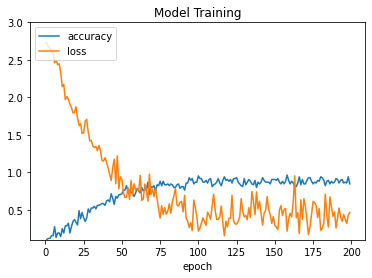

In [82]:
#Results: summarize the history for accuracy
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['loss'])
plt.title('Model Training')
#plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['accuracy', 'loss'], loc='upper left')
plt.ylim(.1,3)
plt.show()

In [83]:
# saving the model 
model.save('chatbotmodel.h5', hist)